  Copyright(c) 2021 UNIADEX, Ltd. All Rights Reserved.  
  CONFIDENTIAL  
  Author: UNIADEX, Ltd.

# 分析
切り出したショットデータを取得し、分析します。  
以下は特定ショットのデータを取得/確認し、特徴点（荷重開始点/最大荷重点/破断点）を抽出、その後全ショットから特徴点を抽出するサンプルコードです。抽出した特徴点はElasticsearchに格納されます。

In [29]:
# ライブラリインポート
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../'))
from backend.cut_out_shot.cut_out_shot import CutOutShot
from backend.common import common
from backend.common.common_logger import logger
from backend.data_reader.data_reader import DataReader
from backend.analyzer.h_one_extract_features import *
from backend.analyzer.analyzer import Analyzer
from backend.utils.df_to_els import *

In [30]:
# ショットデータインデックス一覧
ElasticManager.show_indices(index="shots-*-data")

,index,docs.count,store.size
0,shots-demo-machine-20210709190000-data,2499000,174542
1,shots-machine-01-20210327141514-data,49346,6106
2,shots-machine-01-20210709190000-data,4000000,316782
3,shots-machine-02-20211012103610-data,11526,1456


In [31]:
# 対象データ設定
machine_id = "machine-01"
target_datetime = "20210327141514"
target = machine_id + "-" + target_datetime
shots_data_index = "shots-" + target + "-data"
shots_meta_index = "shots-" + target + "-meta"

# 1ショットで特徴点抽出

## ショット1番を取得して確認

In [32]:
dr = DataReader()

shot_number = 1
shot_df = dr.read_shot(shots_data_index, shot_number=shot_number)
shot_df.head()

,timestamp,sequential_number,sequential_number_by_shot,rawdata_sequential_number,shot_number,tags,load01,load02,load03,load04,stroke_displacement
0,2021-03-27T05:15:14.452260,0,0,45226,1,[],0.058,0.007,0.176,0.142,52.69250
1,2021-03-27T05:15:14.452270,1,1,45227,1,[],0.071,-0.011,0.151,0.130,52.68375
2,2021-03-27T05:15:14.452280,2,2,45228,1,[],0.063,-0.023,0.131,0.120,52.67500
3,2021-03-27T05:15:14.452290,3,3,45229,1,[],0.021,-0.028,0.091,0.084,52.66625
4,2021-03-27T05:15:14.452300,4,4,45230,1,[],-0.005,-0.027,0.031,0.047,52.65750


In [33]:
# ショットメタデータを確認
shots_meta_df = dr.read_shots_meta(shots_meta_index)
shots_meta_df.head()

,shot_number,timestamp,num_of_samples_in_cut_out,spm
0,1,2021-03-27T05:15:14.452260,4925,80.36
1,2,2021-03-27T05:15:15.198860,4929,80.38
2,3,2021-03-27T05:15:15.945350,4931,80.37
3,4,2021-03-27T05:15:16.691900,4944,80.34
4,5,2021-03-27T05:15:17.438700,4922,382.00


In [34]:
# ショットの数を確認
print(f"ショット数：{len(shots_meta_df)}")

ショット数：11


In [35]:
# 80spmを超えるような不正なショットがないか確認
pd.set_option('display.max_rows', 3300)
shots_meta_df[shots_meta_df.spm > 80]

,shot_number,timestamp,num_of_samples_in_cut_out,spm
0,1,2021-03-27T05:15:14.452260,4925,80.36
1,2,2021-03-27T05:15:15.198860,4929,80.38
2,3,2021-03-27T05:15:15.945350,4931,80.37
3,4,2021-03-27T05:15:16.691900,4944,80.34
4,5,2021-03-27T05:15:17.438700,4922,382.00
5,6,2021-03-27T05:15:17.595770,34,101.79
6,7,2021-03-27T05:15:18.185210,4924,80.37
7,8,2021-03-27T05:15:18.931750,4926,80.38
8,9,2021-03-27T05:15:19.678210,4946,80.36
9,10,2021-03-27T05:15:20.424810,4933,80.37


In [36]:
# spm
spm = float(shots_meta_df[shots_meta_df.shot_number == 1].spm)
print(f"spm：{spm}")

spm：80.36


## 特徴点抽出
1ショットから最大荷重点、荷重開始点、破断点を取得します。  

***shot_data***: 対象ショットデータ  
***spm***: spm  
***func***：適用するロジック  
***sub_func***：サブロジック  
***disp_chart***: グラフ表示

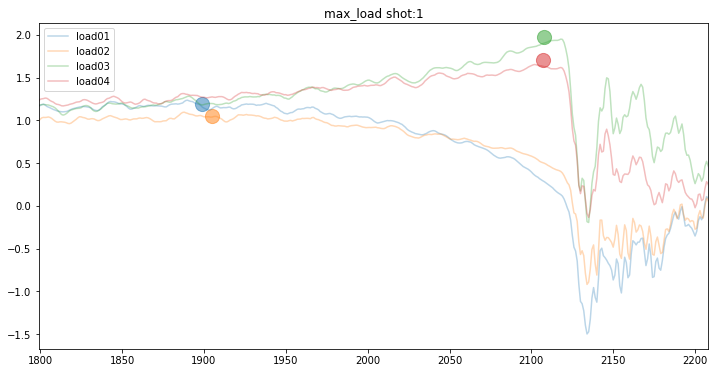

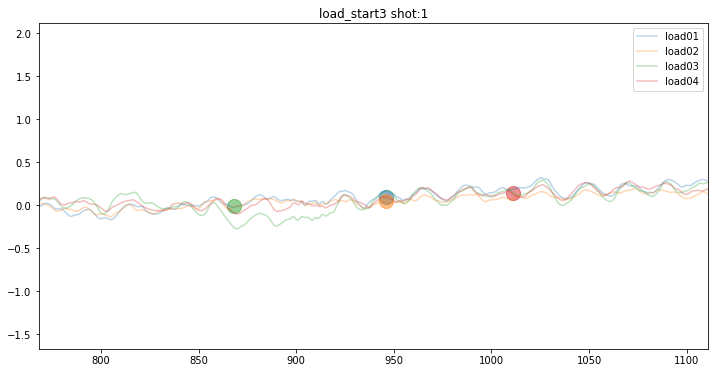

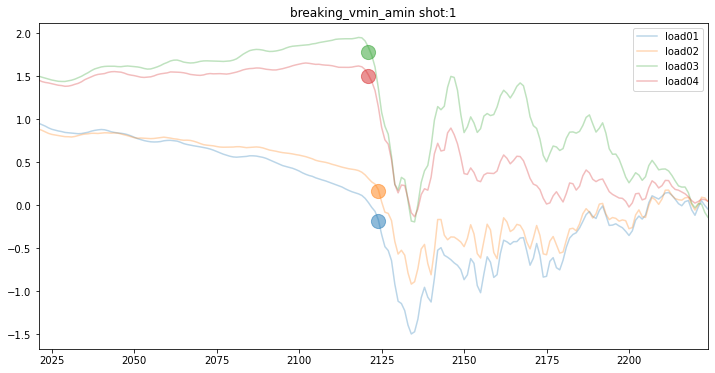

In [37]:
# 最初のショットの最大荷重点、荷重開始点、破断点を確認
max_load_indicies, max_load_values, debug_values = extract_features(shot_data=shot_df, spm=spm, func=max_load, shot=shot_number, disp_chart=True)
load_start_indicies, load_start_values, debug_values = extract_features(shot_df, spm, load_start3, shot=shot_number, disp_chart=True)
break_load_indicies, break_load_values, debug_values = extract_features(shot_df, spm, breaking_vmin_amin, sub_func=narrowing_v4min_mab, shot=shot_number, disp_chart=True)

In [38]:
# 各特徴点のインデックス番号と値を確認
print(f"【最大荷重点】\n indicies：{max_load_indicies}, values：{max_load_values}")
print(f"【荷重開始点】\n indicies：{load_start_indicies}, values：{load_start_values}")
print(f"【破断点】　　\n indicies：{break_load_indicies}, values：{break_load_values}")

【最大荷重点】
 indicies：[1899, 1905, 2108, 2107], values：[1.1913707790282175, 1.0556209399104042, 1.9701115593111462, 1.7032045154015854]
【荷重開始点】
 indicies：[946, 946, 868, 1011], values：[0.09943859649122808, 0.050879699248120296, -0.011884711779448625, 0.13907268170426063]
【破断点】　　
 indicies：[2124, 2124, 2121, 2121], values：[-0.18034167650643665, 0.15912307176132484, 1.7871517237645003, 1.4988795254386822]


# 全ショットから特徴点抽出
全ショットから最大荷重点、荷重開始点、破断点を抽出し、Elasticsearchに保存します。  

***target***: 対象ショットデータ（yyyyMMddHHMMSS）  
***shots_df***: ショットデータのDataFrame
***shots_meta_df***: ショットメタデータのDataFrame  
***feature***: 抽出する特徴点名（max/start/break）  
***func***：適用するロジック  
***sub_func***：サブロジック  
***exclude_shots***: 除外ショット(ex: exclude_shots=(1227, 1228, 1229))  

保存先インデックスは以下になります。  
* 最大荷重点：shots-yyyyMMddHHMMSS-max-point
* 荷重開始点：shots-yyyyMMddHHMMSS-start-point
* 破断点：shots-yyyyMMddHHMMSS-break-point

In [39]:
%%time
dr = DataReader()
shots_df = dr.multi_process_read_all(shots_data_index)

[2021/10/14 00:43:07.345] INFO - data_reader.py#multi_process_read_all:61: データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
[2021/10/14 00:43:07.350] INFO - elastic_manager.py#multi_process_range_scan:326: Data read start. data_count: 49346.
CPU times: user 279 ms, sys: 31.6 ms, total: 311 ms
Wall time: 1.85 s


In [40]:
len(shots_df)

49346

In [41]:
# ショットメタデータ読み込み
shots_meta_df = dr.read_shots_meta(shots_meta_index)

In [42]:
shots_meta_df.head()

,shot_number,timestamp,num_of_samples_in_cut_out,spm
0,1,2021-03-27T05:15:14.452260,4925,80.36
1,2,2021-03-27T05:15:15.198860,4929,80.38
2,3,2021-03-27T05:15:15.945350,4931,80.37
3,4,2021-03-27T05:15:16.691900,4944,80.34
4,5,2021-03-27T05:15:17.438700,4922,382.00


## 全ショットから特徴点抽出
全ショットから最大荷重点、荷重開始点、破断点を抽出し、Elasticsearchに保存します。  

***target***: 対象ショットデータ（yyyyMMddHHMMSS）  
***shots_df***: ショットデータ  
***shots_meta_df***: ショットメタデータ  
***feature***: 抽出する特徴点名（max/start/break）  
***func***：適用するロジック  
***sub_func***：サブロジック  
***exclude_shots***：除外するショット番号（例：exclude_shots=(1227, 1228, 1229)）

保存先インデックスは以下になります。  
* 最大荷重点：shots-yyyyMMddHHMMSS-max-point
* 荷重開始点：shots-yyyyMMddHHMMSS-start-point
* 破断点：shots-yyyyMMddHHMMSS-break-point

In [61]:
# 不正ショットの除外
# exclude_shots=(983, 1227, 1228, 1229, 1369, 1381, 2894)
exclude_shots=(6,)

In [62]:
analyzer = Analyzer(target, shots_df, shots_meta_df, exclude_shots)

In [63]:
# 最大荷重点
analyzer.apply(
    feature="max",
    func=max_load,
    sub_func=None,
)

[2021/10/14 00:46:34.825] INFO - analyzer.py#apply:46: apply start.
[2021/10/14 00:46:34.983] INFO - elastic_manager.py#delete_exists_index:186: delete index 'shots-machine-01-20210327141514-max-point' finished. result: {'acknowledged': True}
[2021/10/14 00:46:35.070] INFO - analyzer.py#_apply_logic:122: shot_number: 6 was excluded.
[2021/10/14 00:46:35.760] INFO - analyzer.py#apply:58: apply finished.


In [60]:
dr = DataReader()
max_index = "shots-" + target + "-max-point"
max_df = dr.read_all(max_index)
max_df

[2021/10/14 00:46:15.691] INFO - data_reader.py#read_all:103: データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
[2021/10/14 00:46:15.698] INFO - data_reader.py#read_all:107: データ件数: 44
[2021/10/14 00:46:15.706] INFO - data_reader.py#read_all:117: Data reading has finished.


,timestamp,shot_number,load,sequential_number,sequential_number_by_shot,value
0,2021-03-27T05:15:14.471250,1,load01,1899,1899,1.191371
1,2021-03-27T05:15:14.471310,1,load02,1905,1905,1.055621
2,2021-03-27T05:15:14.473330,1,load04,2107,2107,1.703205
3,2021-03-27T05:15:14.473340,1,load03,2108,2108,1.970112
4,2021-03-27T05:15:15.218710,2,load03,6910,1985,1.227396
5,2021-03-27T05:15:15.218730,2,load04,6912,1987,1.309242
6,2021-03-27T05:15:15.220230,2,load02,7062,2137,1.506020
7,2021-03-27T05:15:15.220240,2,load01,7063,2138,1.772750
8,2021-03-27T05:15:15.964870,3,load03,11806,1952,1.205897
9,2021-03-27T05:15:15.965320,3,load04,11851,1997,1.275049


In [47]:
# 荷重開始点
analyzer.apply(
    feature="start",
    func=load_start3,
    sub_func=None,
)

[2021/10/14 00:44:25.222] INFO - analyzer.py#apply:46: apply start.
[2021/10/14 00:44:25.456] INFO - elastic_manager.py#delete_exists_index:186: delete index 'shots-machine-01-20210327141514-start-point' finished. result: {'acknowledged': True}
[2021/10/14 00:44:25.617] ERROR - analyzer.py#_apply_logic:145: Failed to apply logic. shot_number: 6. 
Traceback (most recent call last):
  File "/home/jovyan/work/../backend/analyzer/analyzer.py", line 143, in _apply_logic
    indices, values, debug_values = ef.extract_features(shot_df, spm, func, sub_func=sub_func)
  File "/home/jovyan/work/../backend/analyzer/h_one_extract_features.py", line 1101, in extract_features
    i, v, d = func(np.array(shot_data[ch][sub_start:sub_end]), spm, **kwargs)  # ここでnp.arrayになるのでindexがなくなる
  File "/home/jovyan/work/../backend/analyzer/h_one_extract_features.py", line 959, in load_start3
    sd_start = df[100 : df.d.idxmax()].sd.idxmin()  # 100:最大荷重の範囲の荷重最小点 -> sd_start
  File "/opt/conda/lib/python3.9/site-p

In [26]:
dr = DataReader()
start_index = "shots-" + target + "-start-point"
start_df = dr.read_all(start_index)
start_df

[2021/08/17 14:47:16.400] INFO - data_reader.py#read_all:102: データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
[2021/08/17 14:47:16.408] INFO - data_reader.py#read_all:106: データ件数: 120
[2021/08/17 14:47:16.431] INFO - data_reader.py#read_all:116: Data reading has finished.


,timestamp,shot_number,load,sequential_number,sequential_number_by_shot,value
0,2021-03-27T05:15:14.209534,1,load03,1024,1024,0.024113
1,2021-03-27T05:15:14.210305,1,load01,1101,1101,0.082148
2,2021-03-27T05:15:14.210716,1,load02,1142,1142,0.055782
3,2021-03-27T05:15:14.210756,1,load04,1146,1146,0.077231
4,2021-03-27T05:15:14.956247,2,load01,4874,1019,0.029499
5,2021-03-27T05:15:14.956257,2,load03,4875,1020,0.019040
6,2021-03-27T05:15:14.957649,2,load02,5014,1159,0.056263
7,2021-03-27T05:15:14.957649,2,load04,5014,1159,0.076183
8,2021-03-27T05:15:15.701968,3,load03,8627,907,-0.039281
9,2021-03-27T05:15:15.704081,3,load01,8838,1118,0.081223


In [27]:
# 破断点
analyzer.apply(
    feature="break",
    func=breaking_vmin_amin,
    sub_func=narrowing_v4min_mab,
)

[2021/08/17 14:47:21.995] INFO - analyzer.py#apply:45: apply start.
[2021/08/17 14:47:22.132] INFO - elastic_manager.py#delete_exists_index:164: delete index 'shots-machine-01-20210327141514-break-point' finished. result: {'acknowledged': True}
[2021/08/17 14:47:23.318] INFO - analyzer.py#apply:57: apply finished.


In [30]:
dr = DataReader()
break_index = "shots-" + target + "-break-point"
break_df = dr.read_all(break_index)
break_df

[2021/08/17 14:47:45.605] INFO - data_reader.py#read_all:102: データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
[2021/08/17 14:47:45.609] INFO - data_reader.py#read_all:106: データ件数: 120
[2021/08/17 14:47:45.616] INFO - data_reader.py#read_all:116: Data reading has finished.


,timestamp,shot_number,load,sequential_number,sequential_number_by_shot,value,break_channels
0,2021-03-27T05:15:14.222231,1,load03,2292,2292,1.720469,"[load01, load02]"
1,2021-03-27T05:15:14.222231,1,load04,2292,2292,1.520168,"[load01, load02]"
2,2021-03-27T05:15:14.222251,1,load01,2294,2294,-0.145807,"[load01, load02]"
3,2021-03-27T05:15:14.222251,1,load02,2294,2294,0.238791,"[load01, load02]"
4,2021-03-27T05:15:14.968784,2,load03,6126,2271,2.057653,"[load01, load02]"
5,2021-03-27T05:15:14.968784,2,load04,6126,2271,1.710159,"[load01, load02]"
6,2021-03-27T05:15:14.968814,2,load01,6129,2274,-0.378801,"[load01, load02]"
7,2021-03-27T05:15:14.968814,2,load02,6129,2274,0.075030,"[load01, load02]"
8,2021-03-27T05:15:15.716057,3,load03,10034,2314,1.125854,"[load01, load02]"
9,2021-03-27T05:15:15.716057,3,load04,10034,2314,1.086519,"[load01, load02]"
